## How to access and read datacubes from NBS

This tutorial demonstrates how to read and use Copernicus Sentinel-2 datacubes hosted on [satellittdata.no](https://www.satellittdata.no/) - the data portal for Norway’s national ground segment for satellite data (NBS). 

> **Note**: This tutorial is in development. The below functionality should work but we plan to expand this functionality in the future.

## Importing libraries

Note that the tuturial requires some standard libraries which can be installed by `pip install ...`

In [14]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import time

# For georeferencing
import cartopy.crs as ccrs

## Data cube URLs
Data cubes in the NBS project is made available by the original SAFE products, which are converted into [netCDF](https://docs.unidata.ucar.edu/netcdf-c/current/) using the [`safe_to_netcdf`](https://github.com/NasjonaltBakkeSegment/safe_to_netcdf) tool.

These products are disseminated on [nbstds.met.no](https://nbstds.met.no/thredds/catalog/NBS/DATACUBES/catalog.html) (where you can manually browse the catalog). All products contain a so-called OPeNDAP URL, which allows to "stream the data" product and corresponding data over the internet.

> **Note**: We currently have a one-year rolling archive on the Sentinel-2 data in netCDF, such that the datacube URLs suggested below might be outdated and must therefore be replaced


In [8]:
# List of example data cubes

available_dcs = ['https://nbstds.met.no/thredds/dodsC/NetCDF-ondemand-products/datacubes/L2A/T32VNM/datacubes/S2_L2A_T32VNM_2025.ncml',
                 'https://nbstds.met.no/thredds/dodsC/NetCDF-ondemand-products/datacubes/L2A/T32VNM/datacubes/S2_L2A_T32VNM_2024.ncml',                 
                ]



## Reading datacubes 
Now we want to read the datacubes. Below we provide two different options, namely the native netcdf4 package in python and xarray, where the latter is becoming a standard tool in the geophysics community

> **Note**: If the datacube havent been read for a while, it is not cached on the server, and the read time would typically be on the order of a minute. If it has been read recently, and thus cached, read time is typically around a couple of seconds


In [12]:
use_netcdf4 = False
# Iterate through list of DCs
for dc in available_dcs:
    start_reading = time.time()
    
    # Reading the data. NOTE: Might take some time    
    if use_netcdf4:
        try:
            ncin = Dataset(dc)
        except:
            print('Exception for {}'.format(dc))            
    else:
        try:
            ncin = xr.open_dataset(dc)
        except:
            print('Exception for {}'.format(dc))

    # Monitoring the read time
    end_reading = time.time()
    dt = end_reading - start_reading
    print(f'Read time in seconds: {dt}')



Read time in seconds: 18.62463355064392
Read time in seconds: 24.062914848327637


## Spatio-temporal coverage of the data cube

Spatial covergae: Plot the tile on a map  

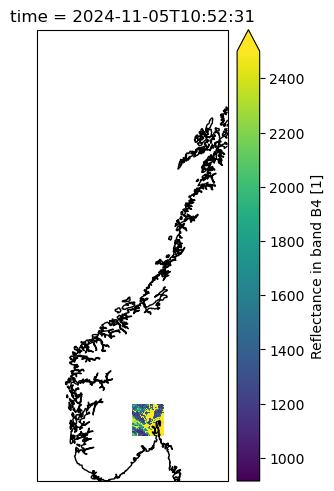

In [35]:
projection = ccrs.epsg(ncin.UTM_projection.epsg_code)
fig = plt.figure(layout='compressed')
ax = fig.add_subplot(1, 1, 1, projection=projection)

ncin.B4.isel(time=12)[::20,::20].plot(vmax=2500)

#ax.set_xlim(0,20,crs=ccrs.PlateCarree())

ax.set_extent([0,25,58,72],crs=ccrs.PlateCarree())
ax.coastlines()


Temporal covergae: Number of products within data cube period

In [78]:
date_start=ncin.time.min().values
date_end=ncin.time.max().values

# Convert to datetime64[D] to get only the date
date_start = date_start.astype('datetime64[D]')
date_end = date_end.astype('datetime64[D]')

print(f"Number of scenes from {date_start} to {date_end}: {ncin.time.size}")

Number of scenes from 2024-01-02 to 2024-12-30: 208


Text(0, 0.5, 'Relative orbit number')

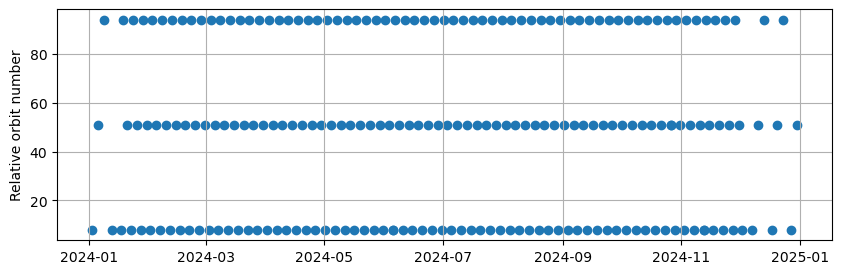

In [99]:
# Plotting acquisition time as a function of relative orbit number

fig,ax=plt.subplots(figsize=(10,3))

ax.scatter(ncin.time,ncin.orbit_data.isel(orbit_dim=0).values)
ax.grid()
ax.set_ylabel('Relative orbit number')


In [112]:
#tile_coverage = [np.isnan(ncin.B4.isel(time=i)).sum()/(10980*10980) for i in range(ncin.time.size)]

## Inspecting the data
The datacubes are just a virtual concatenation of the single products. In essence, OPeNDAP allows to merge products along a specific dimension (here time), such that we can obtain a time-aggregate of all pixel values for a specific tile. 

In [113]:
ncin

<xarray.Dataset> Size: 2TB
Dimensions:         (x: 10980, y: 10980, raster_band_id: 13, time: 208, ya: 22,
                     xa: 22, orbit_dim: 3)
Coordinates:
  * x               (x) int32 44kB 499980 499990 500000 ... 609750 609760 609770
  * y               (y) int32 44kB 6700020 6700010 6700000 ... 6590240 6590230
  * time            (time) datetime64[ns] 2kB 2024-02-22T11:00:51 ... 2024-01...
Dimensions without coordinates: raster_band_id, ya, xa, orbit_dim
Data variables: (12/24)
    band_id         (raster_band_id) int32 52B ...
    UTM_projection  int32 4B ...
    view_azimuth    (time, raster_band_id, ya, xa) float32 5MB ...
    view_zenith     (time, raster_band_id, ya, xa) float32 5MB ...
    sun_zenith      (time, ya, xa) float32 403kB ...
    sun_azimuth     (time, ya, xa) float32 403kB ...
    ...              ...
    B9              (time, y, x) float32 100GB ...
    MSK_CLDPRB      (time, y, x) float32 100GB ...
    MSK_SNWPRB      (time, y, x) float32 100GB ...
    AOT             (time, y, x) float32 100GB ...
    WVP             (time, y, x) float32 100GB ...
    SCL             (time, y, x) float32 100GB ...
Attributes: (12/108)
    AOT_QUANTIFICATION_VALUE:              1000.0
    AOT_QUANTIFICATION_VALUE_UNIT:         none
    AOT_RETRIEVAL_ACCURACY:                0.0
    AOT_RETRIEVAL_METHOD:                  CAMS
    BOA_QUANTIFICATION_VALUE:              10000
    BOA_QUANTIFICATION_VALUE_UNIT:         none
    ...                                    ...
    time_coverage_end:                     2024-07-26T10:56:19.024Z
    orbit_number:                          38587
    geospatial_lon_min:                    8.999636636826697
    geospatial_lat_min:                    59.61830270311267
    geospatial_lon_max:                    9.644032081402523
    geospatial_lat_max:                    60.43645676802676

## Read data for further processing 

Now that we have read the data cube, we can start looking more into the data. The final processing is very user-dependent. However, we show some general ways of reading the data and playing around with some of the variables.

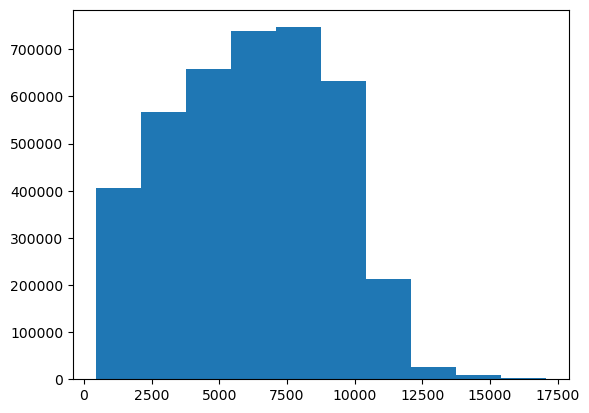

In [36]:
# Test reading an plotting a the reflectance intensity in a subset (in both space and time) of the data cube
tmp=ncin.B4.isel(x=slice(1000,1500),y=slice(1000,1500),time=range(0,16))
plt.hist(tmp.values.ravel());plt.show()